In [2]:
!gdown 1seOAJxGY0MxdR90-emKqGFY0ejUcp8tn
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1seOAJxGY0MxdR90-emKqGFY0ejUcp8tn
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 374kB/s]


In [1]:
!kaggle datasets download paramaggarwal/fashion-product-images-dataset

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
License(s): MIT
100% 23.1G/23.1G [19:15<00:00, 19.0MB/s]
100% 23.1G/23.1G [19:15<00:00, 21.4MB/s]


In [7]:
!unzip fashion-product-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: fashion-dataset/styles/58128.json  
  inflating: fashion-dataset/styles/58129.json  
  inflating: fashion-dataset/styles/5813.json  
  inflating: fashion-dataset/styles/58131.json  
  inflating: fashion-dataset/styles/58132.json  
  inflating: fashion-dataset/styles/58133.json  
  inflating: fashion-dataset/styles/58135.json  
  inflating: fashion-dataset/styles/58136.json  
  inflating: fashion-dataset/styles/58137.json  
  inflating: fashion-dataset/styles/58138.json  
  inflating: fashion-dataset/styles/58139.json  
  inflating: fashion-dataset/styles/5814.json  
  inflating: fashion-dataset/styles/58140.json  
  inflating: fashion-dataset/styles/58141.json  
  inflating: fashion-dataset/styles/58143.json  
  inflating: fashion-dataset/styles/58144.json  
  inflating: fashion-dataset/styles/58145.json  
  inflating: fashion-dataset/styles/58146.json  
  inflating: fashion-dataset/styles/58147.json  
  inflating: fashion

# Import necessary libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import datasets
import cv2
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from pandas.core.common import flatten
from torchvision.transforms import transforms
import torchvision.models as models
from torch.autograd import Variable
from PIL import Image

## Read images

In [13]:
fashion_data = pd.read_csv('fashion-dataset/styles.csv', on_bad_lines='skip')

In [14]:
fashion_copy = fashion_data.copy()

In [15]:
fashion_copy['image_path'] = fashion_copy.apply(lambda row: str(row['id']) + '.jpg', axis=1)
fashion_copy = fashion_copy.reset_index(drop=True)

In [20]:
def get_image_path(image_name):
    base_path = "fashion-dataset/images/"
    full_path = base_path + image_name
    return full_path

## Display sample images


In [21]:
def load_image(image_name):
    image = cv2.imread(get_image_path(image_name))
    return image

In [22]:
# Display some images
def display_images(image_dict, rows=1, cols=1, figsize=(12, 12)):
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=figsize)

    for idx, name in enumerate(image_dict):
        axes.ravel()[idx].imshow(cv2.cvtColor(image_dict[name], cv2.COLOR_BGR2RGB))
        axes.ravel()[idx].set_title(name)
        axes.ravel()[idx].set_axis_off()

    plt.tight_layout()

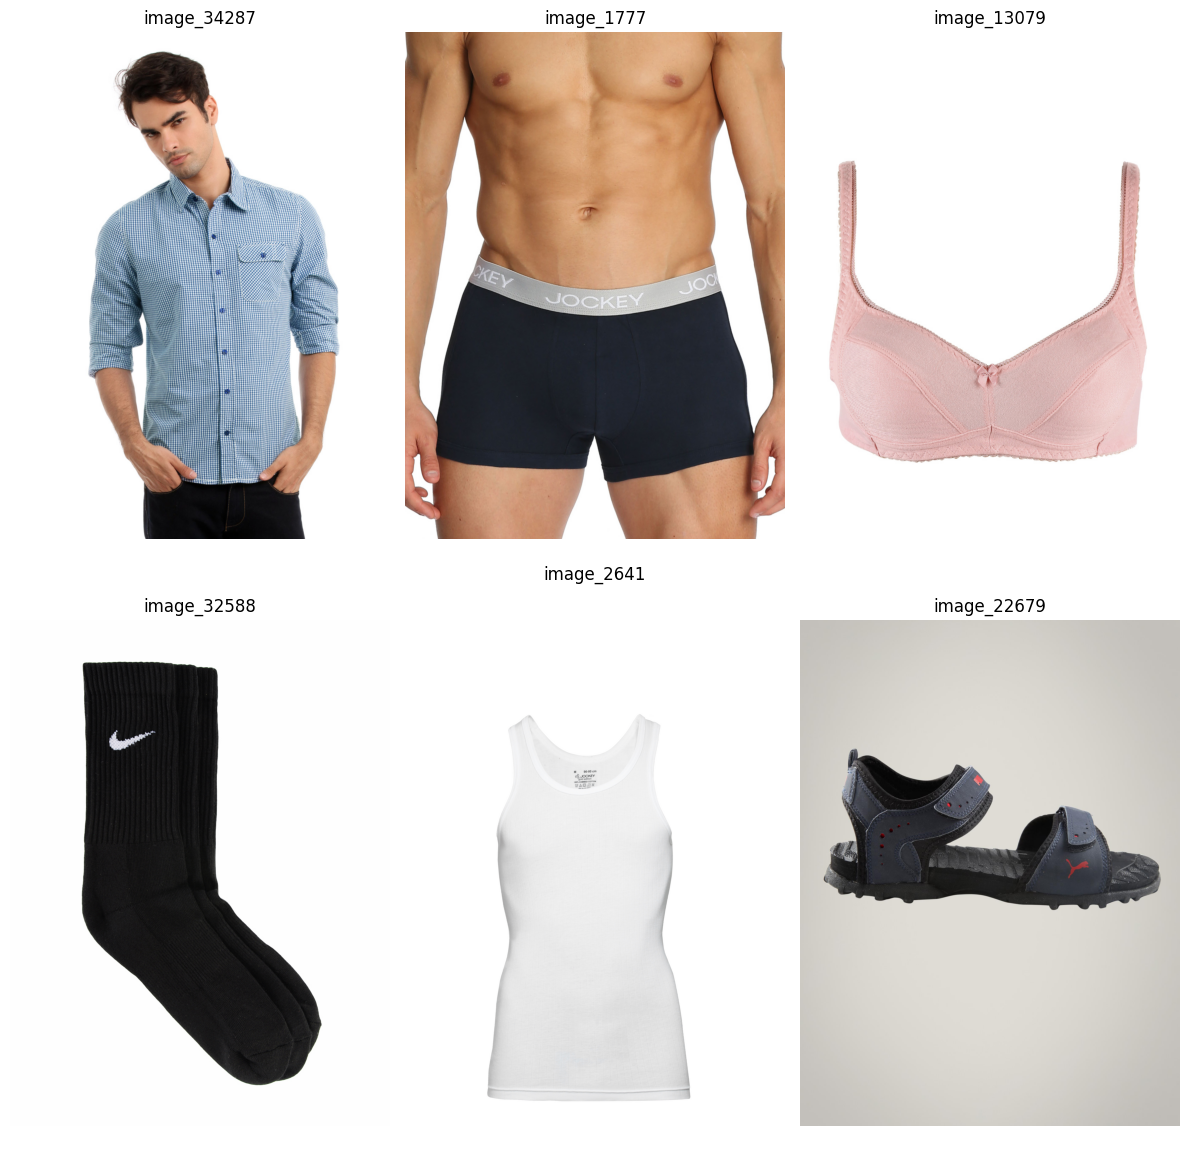

In [23]:
sample_images = {'image_' + str(i): load_image(row.image_path) for i, row in fashion_copy.sample(6).iterrows()}
display_images(sample_images, 2, 3)

In [24]:
fashion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [25]:
fashion_data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [26]:
fashion_data = fashion_data.drop(columns = ["id"])

# EDA

## Frequency of Products

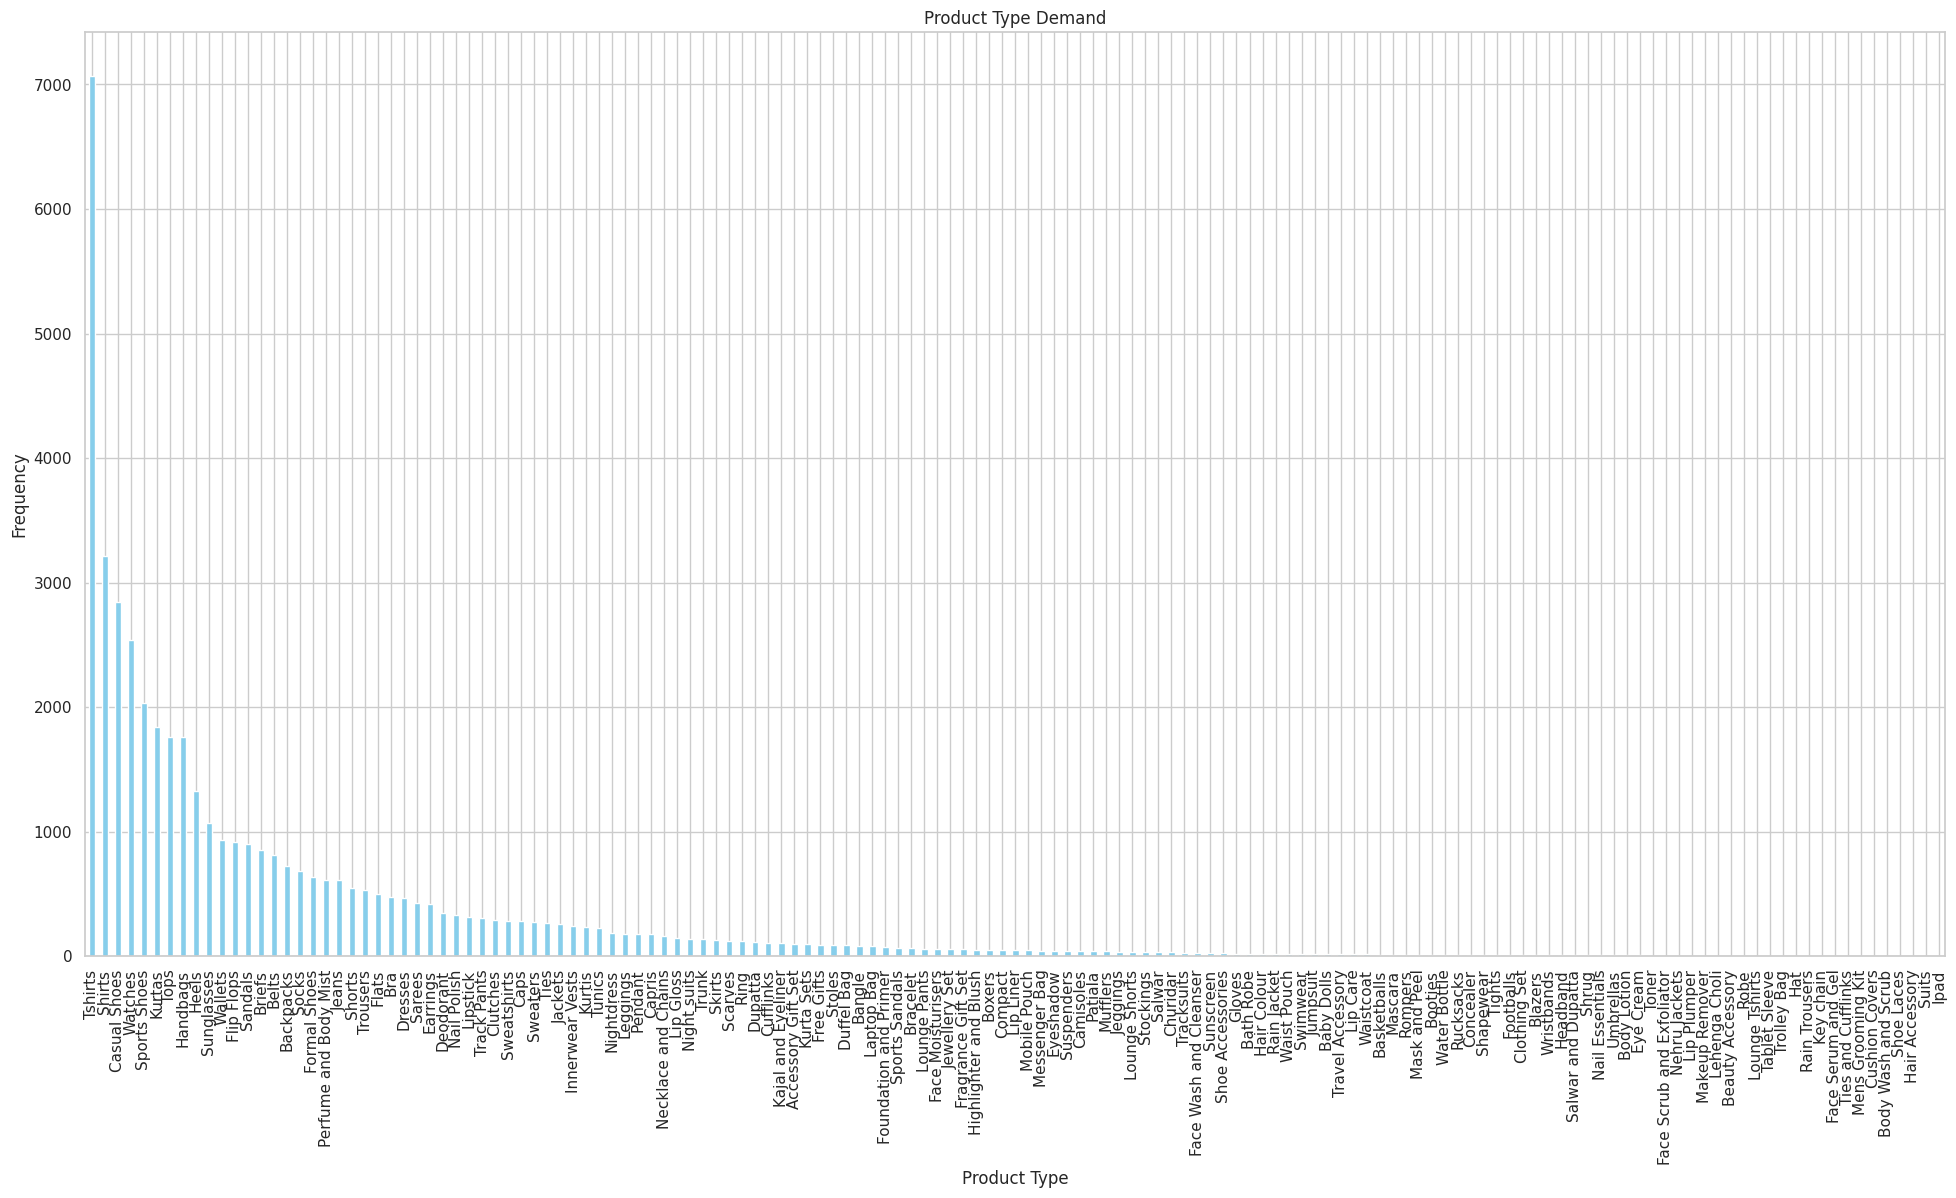

In [56]:
plt.figure(figsize=(24, 12))
fashion_data['articleType'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Product Type Demand')
plt.xlabel('Product Type')
plt.ylabel('Frequency')
plt.show()

## Top 10 Most Popular Product Types

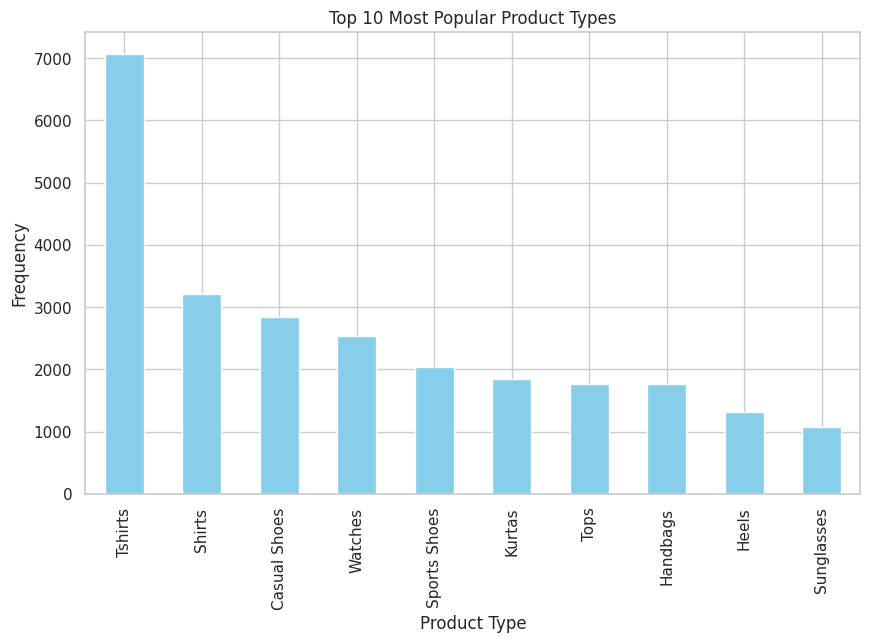

In [57]:
plt.figure(figsize=(10, 6))
fashion_data['articleType'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Popular Product Types')
plt.xlabel('Product Type')
plt.ylabel('Frequency')
plt.show()

## Product Category Distribution by Gender

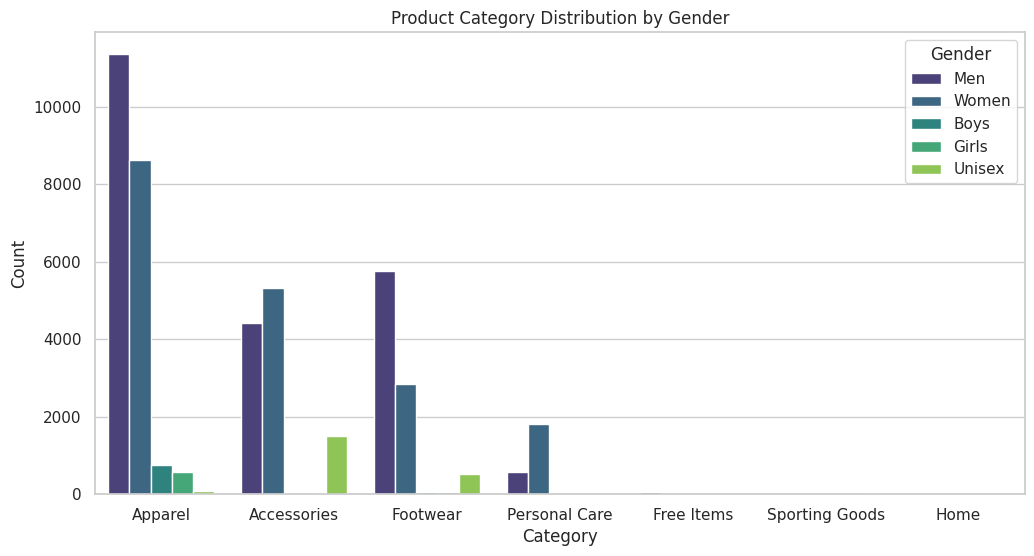

In [60]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.countplot(data=fashion_data, x='masterCategory', hue='gender', palette='viridis')
plt.title('Product Category Distribution by Gender')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

## Seasonal Product Distribution by Gender

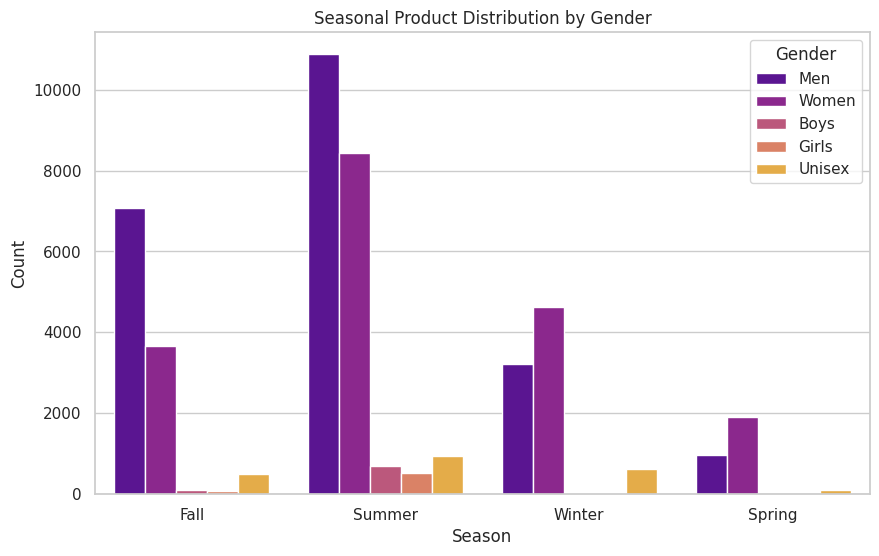

In [59]:
plt.figure(figsize=(10, 6))
sns.countplot(data=fashion_data, x='season', hue='gender', palette='plasma')
plt.title('Seasonal Product Distribution by Gender')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

## Product Variability by Color and Season

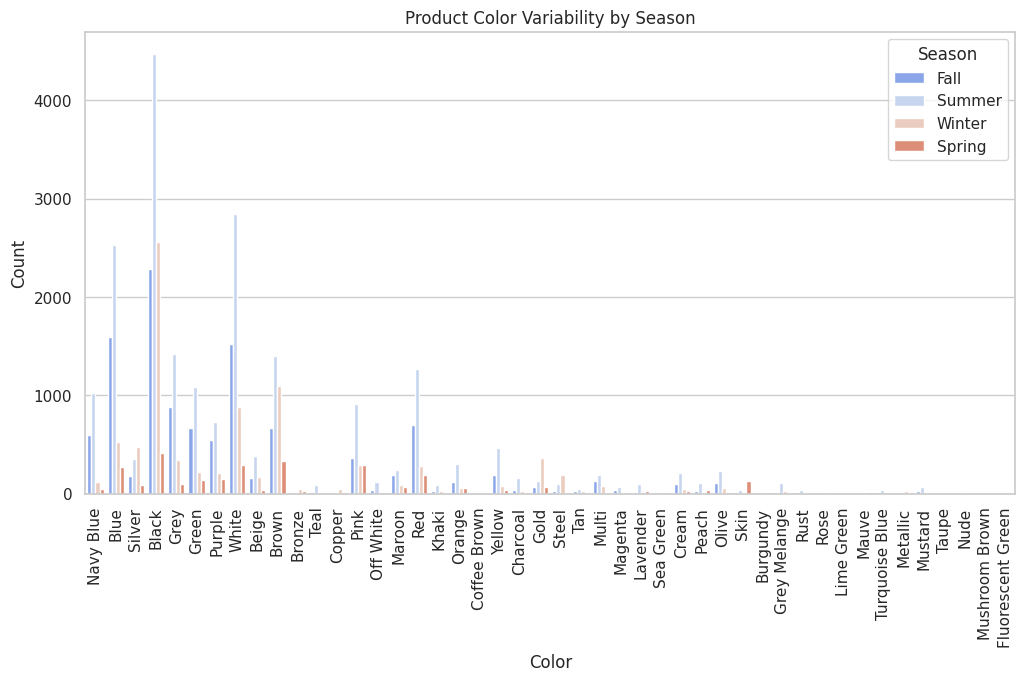

In [61]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fashion_data, x='baseColour', hue='season', palette='coolwarm')
plt.title('Product Color Variability by Season')
plt.xlabel('Color')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Season')
plt.show()

## Get top colors for each season

<ipython-input-62-79c31a3c1dd7>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_colors = season_color_count.groupby('season').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


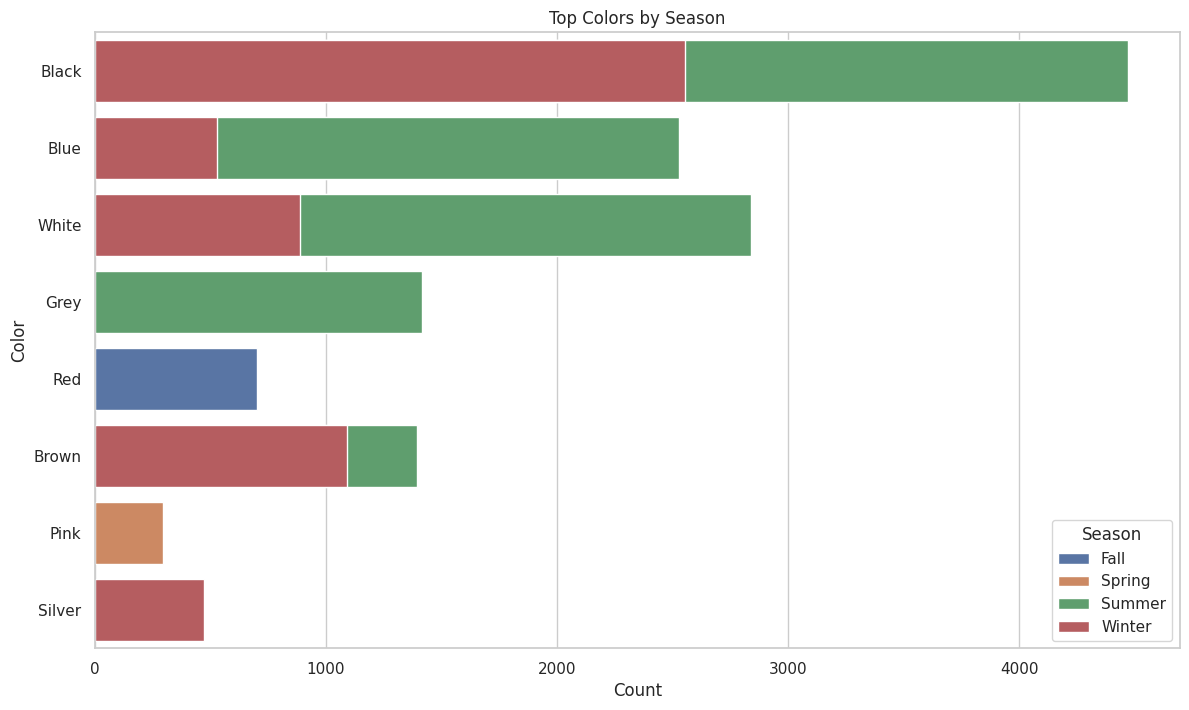

In [62]:
# Group by season and color to count occurrences
season_color_count = fashion_data.groupby(['season', 'baseColour']).size().reset_index(name='count')


top_colors = season_color_count.groupby('season').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.barplot(data=top_colors, x='count', y='baseColour', hue='season', dodge=False)
plt.title('Top Colors by Season')
plt.xlabel('Count')
plt.ylabel('Color')
plt.legend(title='Season')
plt.show()

## Distribution of Product Usage

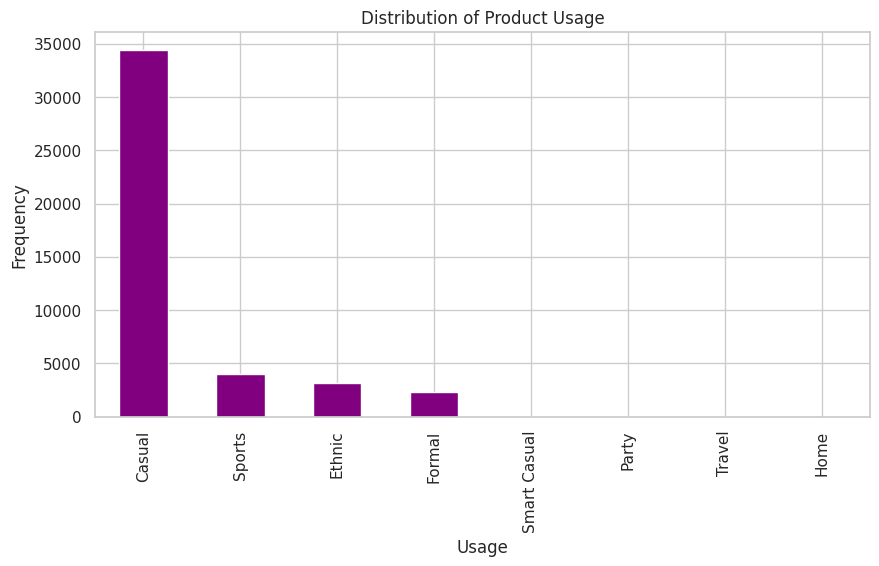

In [63]:
usage_counts = fashion_data['usage'].value_counts()
plt.figure(figsize=(10, 5))
usage_counts.plot(kind='bar', color='purple')
plt.title('Distribution of Product Usage')
plt.xlabel('Usage')
plt.ylabel('Frequency')
plt.show()

## Top 10 Colors Across All Products

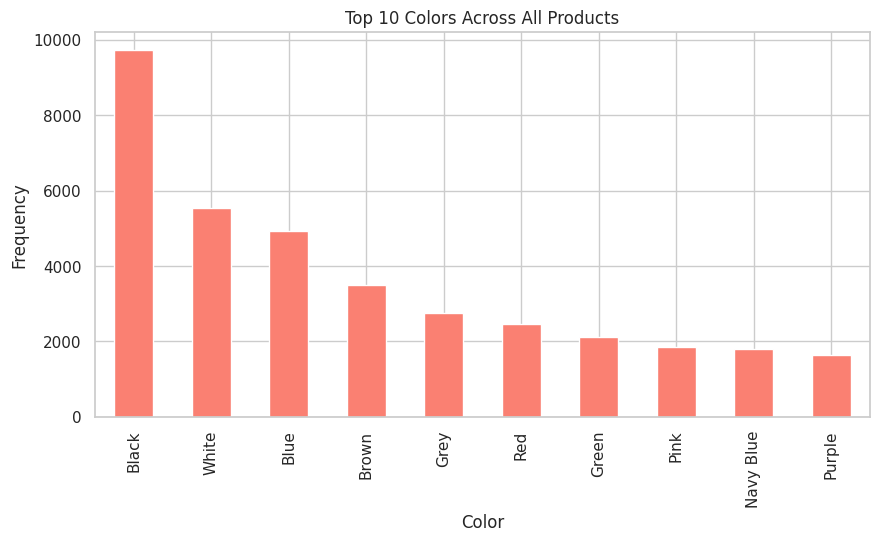

In [64]:
color_counts = fashion_data['baseColour'].value_counts().head(10)
plt.figure(figsize=(10, 5))
color_counts.plot(kind='bar', color='salmon')
plt.title('Top 10 Colors Across All Products')
plt.xlabel('Color')
plt.ylabel('Frequency')
plt.show()

## Top Colors by Season

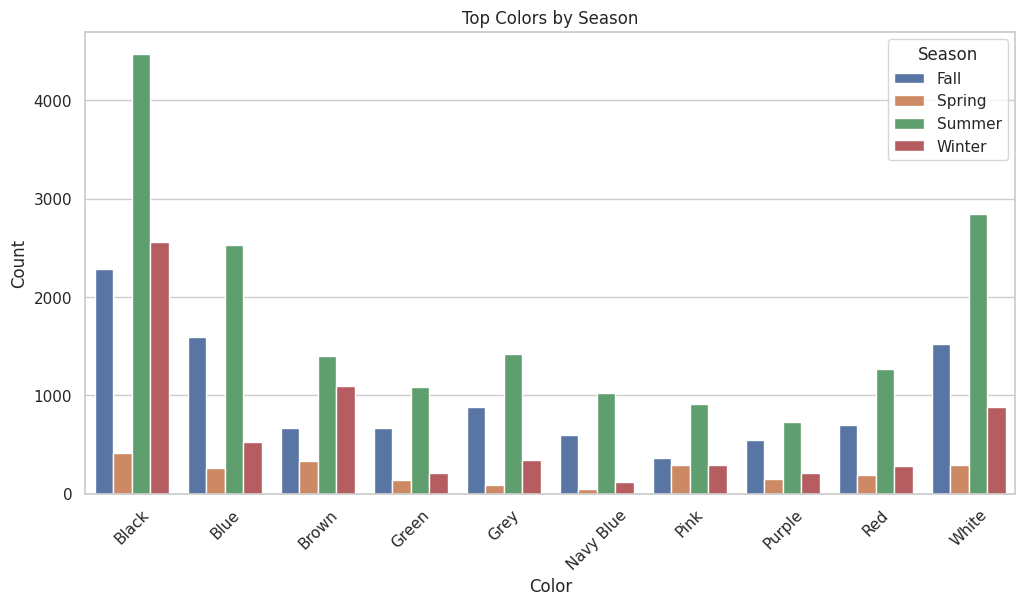

In [65]:
sns.set(style="whitegrid")

# Seasonal Trends for Colors (Top Colors Only)
top_colors = fashion_data['baseColour'].value_counts().head(10).index  # Top 10 colors overall
top_colors_by_season = fashion_data[fashion_data['baseColour'].isin(top_colors)].groupby(['season', 'baseColour']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_colors_by_season, x='baseColour', y='count', hue='season')
plt.title('Top Colors by Season')
plt.xlabel('Color')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Season')
plt.show()

## Heatmap for Product Type vs. Season

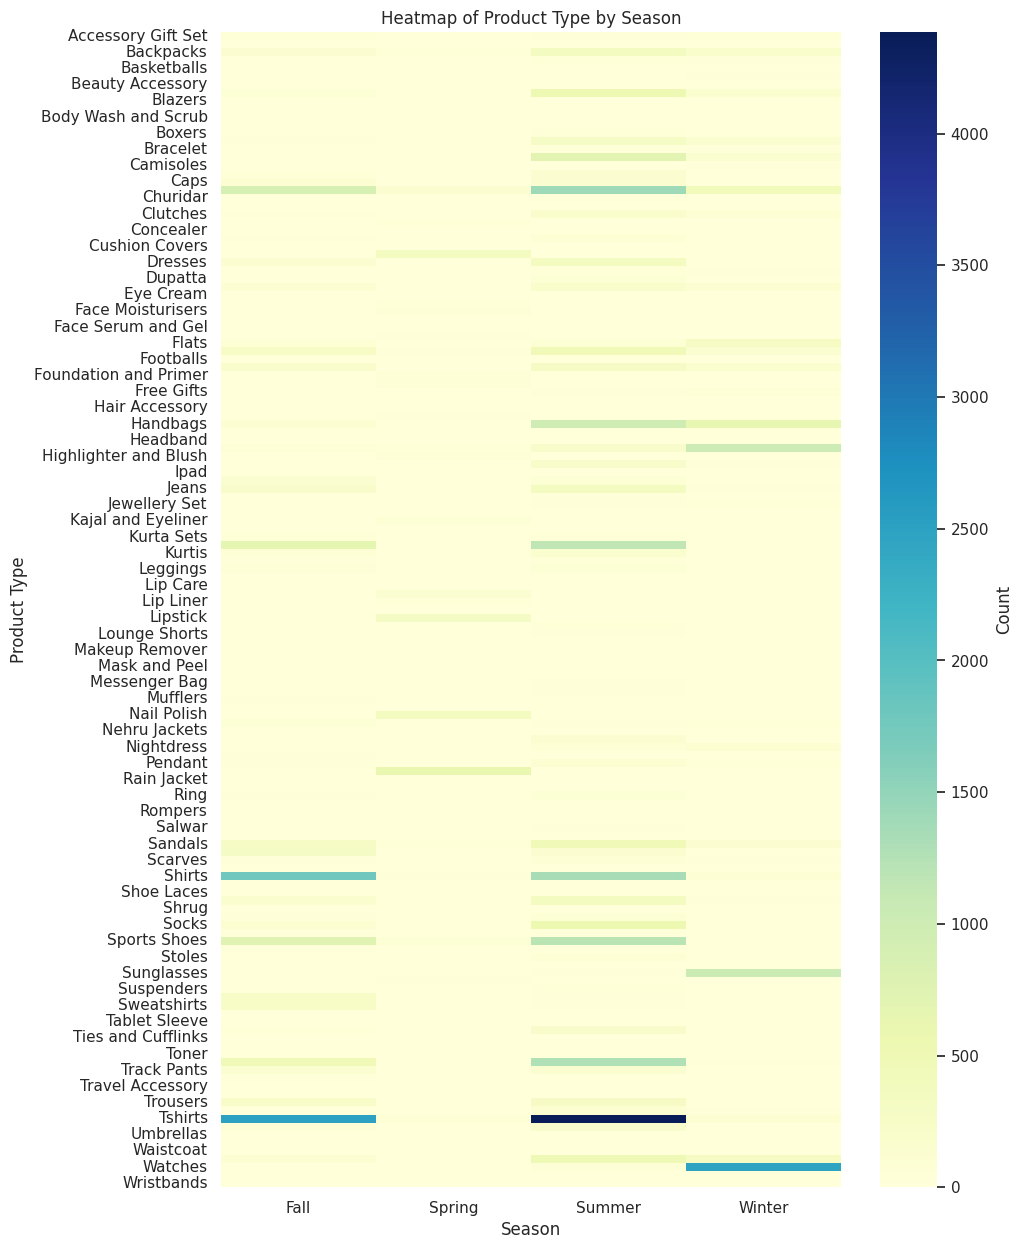

In [66]:
product_season_pivot = fashion_data.pivot_table(index='articleType', columns='season', aggfunc='size', fill_value=0)
plt.figure(figsize=(10, 15))
sns.heatmap(product_season_pivot, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Count'})
plt.title('Heatmap of Product Type by Season')
plt.xlabel('Season')
plt.ylabel('Product Type')
plt.show()

## Distribution of Master Categories by Season

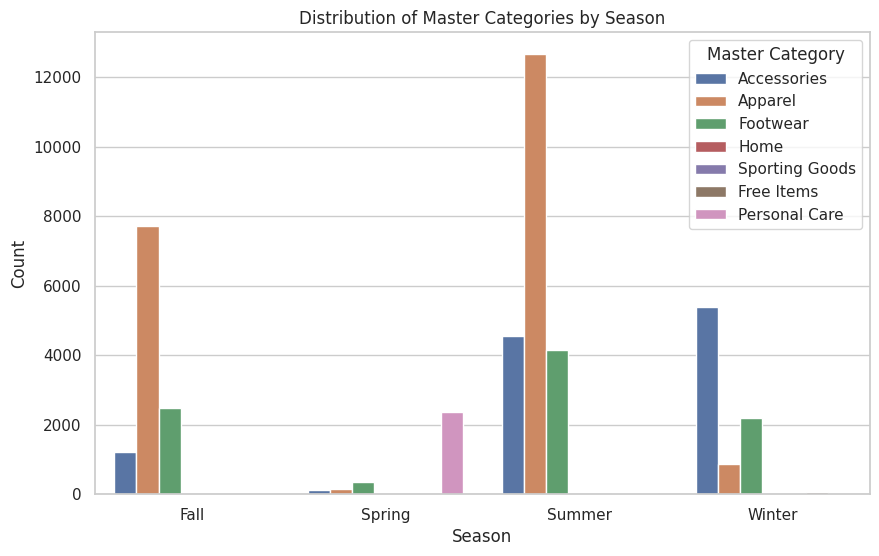

In [67]:
category_season_counts = fashion_data.groupby(['season', 'masterCategory']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=category_season_counts, x='season', y='count', hue='masterCategory')
plt.title('Distribution of Master Categories by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Master Category')
plt.show()

## Get top 10 product types for each season

<ipython-input-68-9ddd3c660439>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_product_types = season_product_count.groupby('season').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)


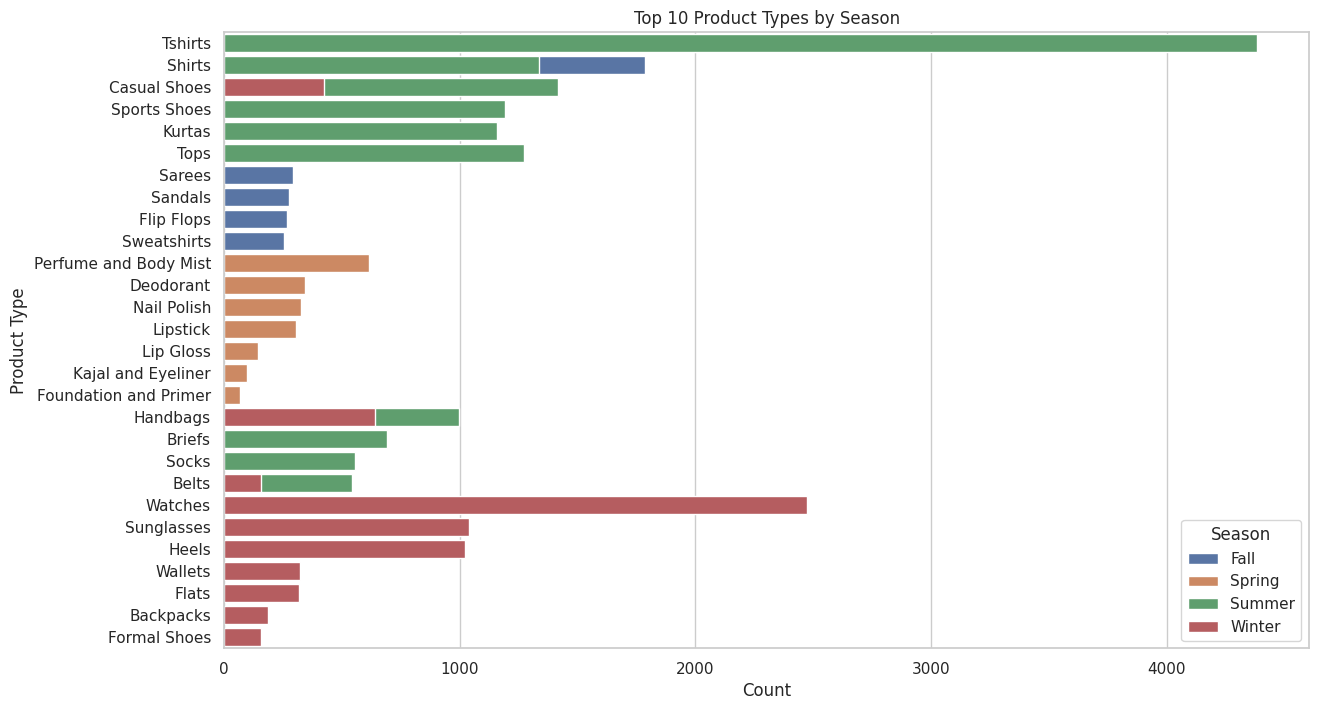

In [68]:
# Group by season and product type to count occurrences
season_product_count = fashion_data.groupby(['season', 'articleType']).size().reset_index(name='count')

top_product_types = season_product_count.groupby('season').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.barplot(data=top_product_types, x='count', y='articleType', hue='season', dodge=False)
plt.title('Top 10 Product Types by Season')
plt.xlabel('Count')
plt.ylabel('Product Type')
plt.legend(title='Season')
plt.show()

## Get top colors for each season

<ipython-input-69-438f2b510c6f>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_colors = season_color_count.groupby('season').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


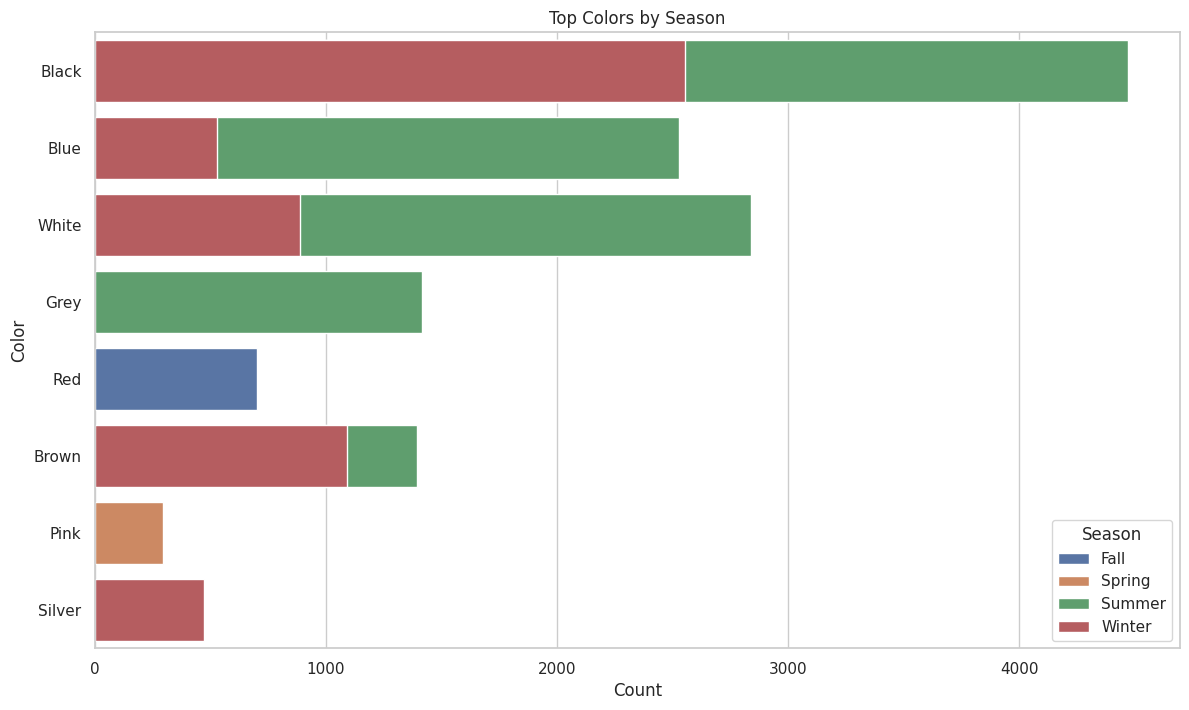

In [69]:
# Group by season and color to count occurrences
season_color_count = fashion_data.groupby(['season', 'baseColour']).size().reset_index(name='count')

top_colors = season_color_count.groupby('season').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.barplot(data=top_colors, x='count', y='baseColour', hue='season', dodge=False)
plt.title('Top Colors by Season')
plt.xlabel('Count')
plt.ylabel('Color')
plt.legend(title='Season')
plt.show()


## Group by season and master category to count occurrences

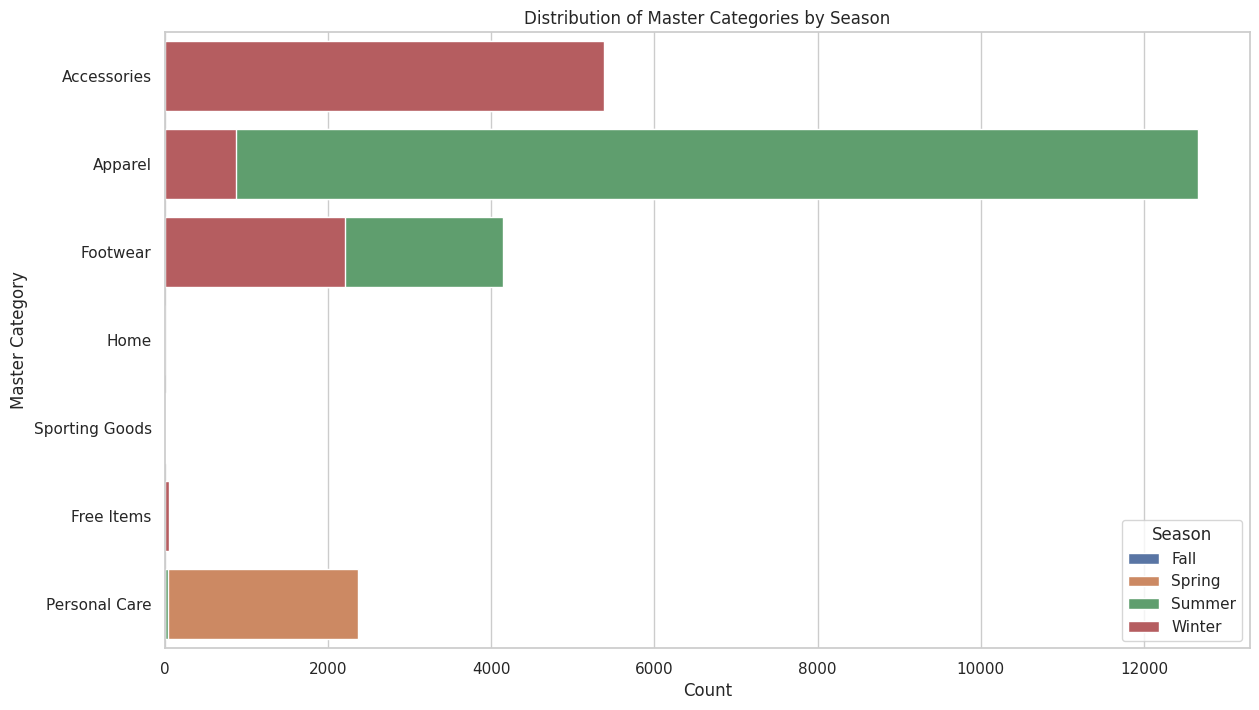

In [70]:
season_master_category_count = fashion_data.groupby(['season', 'masterCategory']).size().reset_index(name='count')

plt.figure(figsize=(14, 8))
sns.barplot(data=season_master_category_count, x='count', y='masterCategory', hue='season', dodge=False)
plt.title('Distribution of Master Categories by Season')
plt.xlabel('Count')
plt.ylabel('Master Category')
plt.legend(title='Season')
plt.show()

## Seasonal trends plot

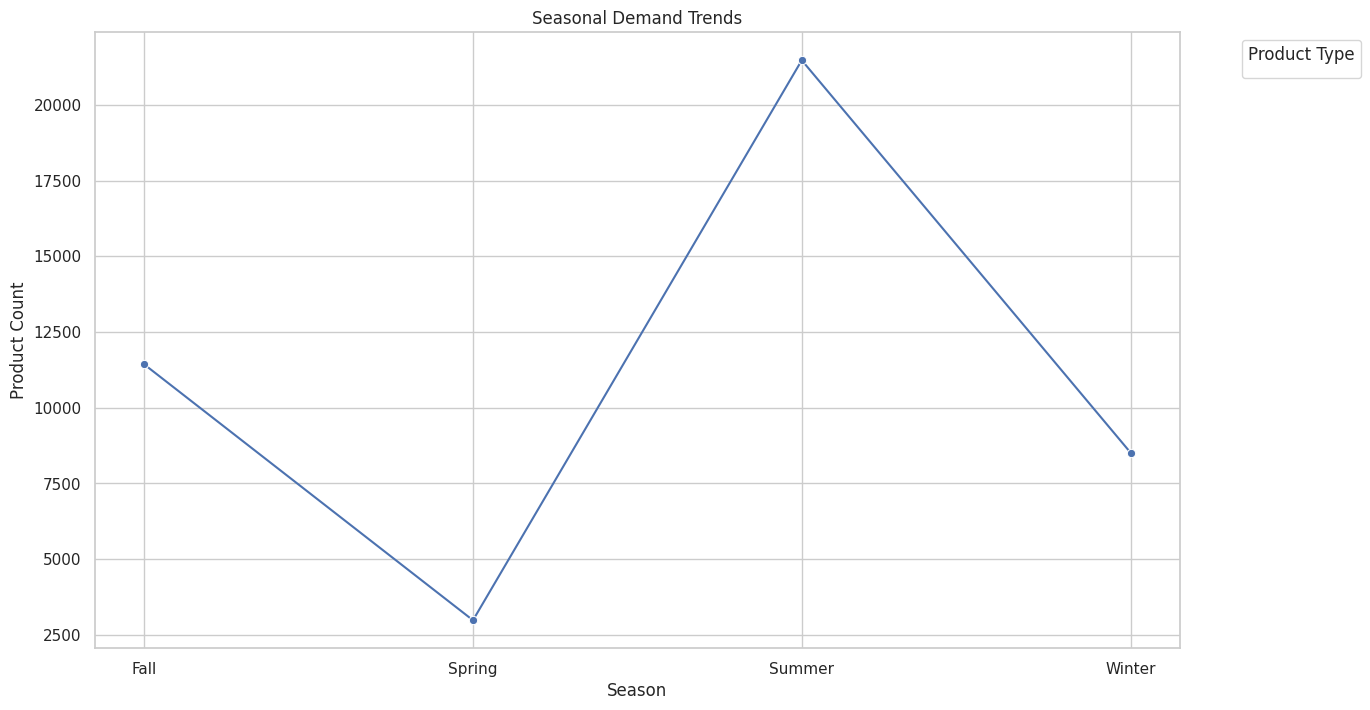

In [71]:
# We can calculate the product demand trend for each season and identify any inventory spikes or drops
seasonal_trends = fashion_data.groupby(['season']).size().reset_index(name='count')

plt.figure(figsize=(14, 8))
sns.lineplot(data=seasonal_trends, x='season', y='count', marker='o')
plt.title('Seasonal Demand Trends')
plt.xlabel('Season')
plt.ylabel('Product Count')
plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

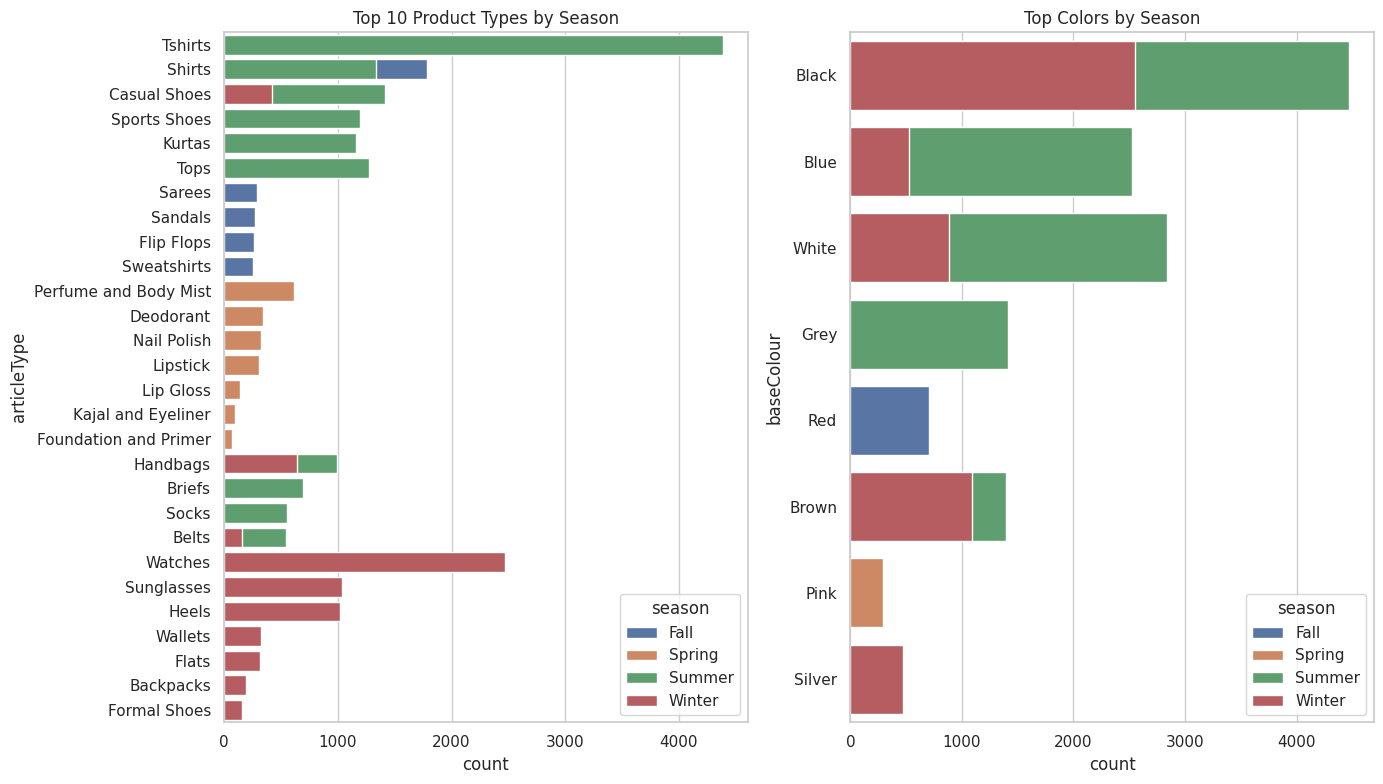

In [49]:
# Plot marketing opportunities: seasonal product type and color demand
plt.figure(figsize=(14, 8))

# Top product types by season
plt.subplot(1, 2, 1)
sns.barplot(data=top_product_types, x='count', y='articleType', hue='season', dodge=False)
plt.title('Top 10 Product Types by Season')

# Top colors by season
plt.subplot(1, 2, 2)
sns.barplot(data=top_colors, x='count', y='baseColour', hue='season', dodge=False)
plt.title('Top Colors by Season')

plt.tight_layout()
plt.show()